In [1]:
import matplotlib.pyplot as plt
import numpy as np

from timescales.sim import sim_spikes_synaptic
from timescales.est import compute_acf, fit_acf, fit_psd

## Manuscript Figures

### Figure 1

Timscale Methods & Applications

- Traditional ACF approach
    - Avg. ACF of population
- Related Errors
    - Bias (Bayes paper) <- need to implement
        - Limits event-related application
        - Multiple Trials (ACF vs Spectral)
    - Oscillations
        - SpecParam
        - ACF + Cos
        
Below, each trace is a separate neuron (equivalent to a separate trial). 100 neurons/trials were simulated, each with 2s of signal, simulating an event-related design.

/home/voytek/projects/timescale-methods/timescales/est/psd.py:90: RuntimeWarning: invalid value encountered in double_scalars
  knee_freq = knee**(1./exponent)


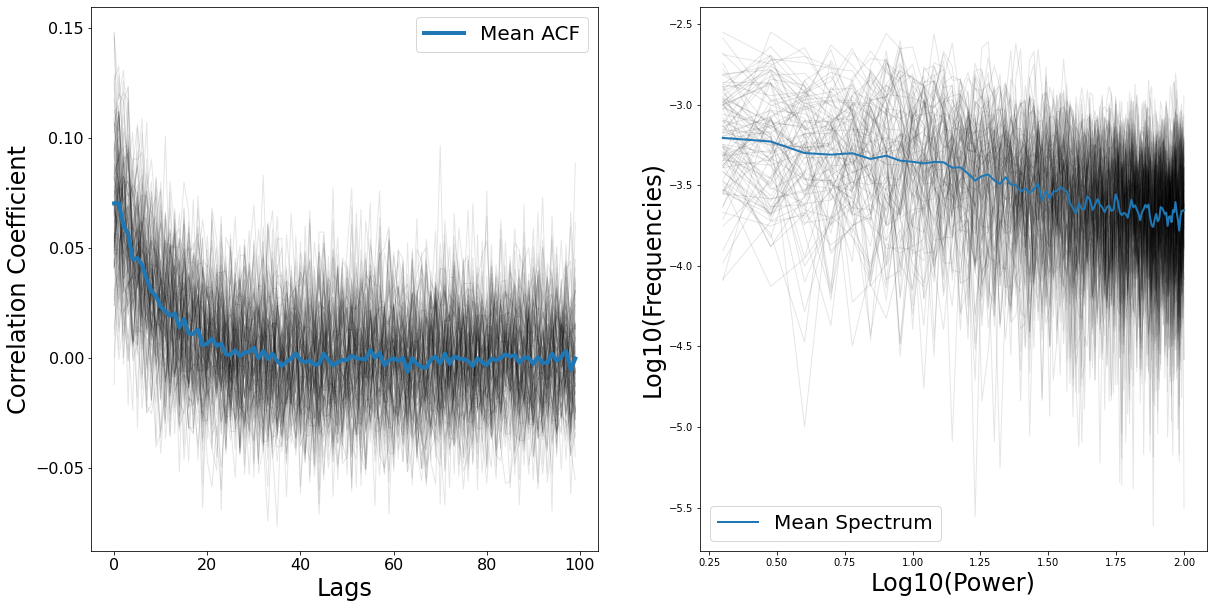

In [5]:
# Settings
n_seconds = 2
fs = 1000
tau = 0.01
var_noise = .25
n_trials = 100 # could also be interpreted as independent neurons

# Simulate Spikes
spikes = np.zeros((n_trials, int(n_seconds * fs)))
#probs = np.zeros((n_trials, int(n_seconds * fs)))
for i in range(n_trials):
    _probs, _spikes = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1,
                                          var_noise=var_noise, return_sum=False)
    spikes[i] = _spikes
    #probs[i] = _probs
    
# Compute ACF
corrs = compute_acf(spikes, 100)

# Plot ACF
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))

for ind, c in enumerate(corrs):
    axes[0].plot(c, color='k', alpha=.1, lw=1)
    
axes[0].plot(corrs.mean(axis=0), label=f'Mean ACF', lw=4)
axes[0].legend(fontsize=20)

    
axes[0].set_xlabel('Lags', fontsize=24)
axes[0].set_ylabel('Correlation Coefficient', fontsize=24)

axes[0].tick_params(axis='x', labelsize=16)
axes[0].tick_params(axis='y', labelsize=16)

# Fit Spectra - skip 1hz to reduce noise
fg, kf, kt = fit_psd(spikes, fs, (2, 100), fooof_init={'max_n_peaks': 0})

# Plot Spectra
for p in fg.power_spectra:
    axes[1].plot(np.log10(fg.freqs), p, color='k', alpha=.1, lw=1)
    
axes[1].plot(np.log10(fg.freqs), np.mean(fg.power_spectra, axis=0), lw=2, color='C0', label='Mean Spectrum')
axes[1].set_xlabel('Log10(Power)', fontsize=24)
axes[1].set_ylabel('Log10(Frequencies)', fontsize=24);
axes[1].legend(fontsize=20);

Sim Tau: 0.01
Tau Dist Mean 0.017719450817531256
Mean of ACF's Tau: 0.00933691797143479


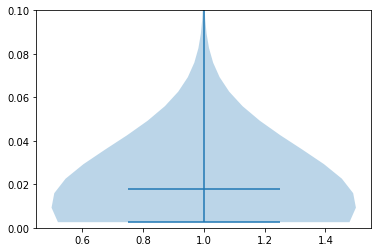

In [18]:
# This supports Murray et al., 2014:
#   Take the mean of the ACF before computing Tau

params_acf = fit_acf(corrs)
params_acf_mean = fit_acf(corrs.mean(axis=0))

plt.violinplot(params_acf[:, 1]/fs, showmeans=True, widths=1);
plt.ylim(0, .1)

print('Sim Tau: 0.01')
print(f'Tau Dist Mean {(params_acf[:, 1]/fs).mean()}')
print(f"Mean of ACF's Tau: {(params_acf_mean[1]/fs).mean()}")

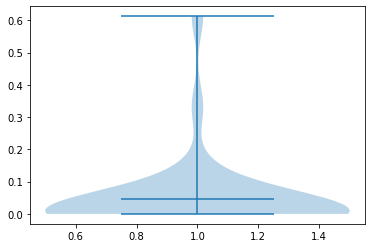

In [30]:
fg, knee_freq, knee_tau = fit_psd(spikes, fs, (2, 100))
fg_mean, knee_freq_mean, knee_tau_mean = fit_psd(spikes.mean(axis=0), fs, (2, 100))

inds = np.where((~np.isnan(knee_tau)) & (kt > 0) & (kt < 1))[0]

plt.violinplot(knee_tau[inds], showmeans=True, widths=1);
print('Sim Tau: 0.01')
print(f'Tau Dist Mean {(knee_tau[inds]).mean()}')
print(f"Mean of Spec's Tau: {(knee_tau_mean).mean()}")

In [ ]:
# Settings
fs = 1000
tau = 0.1
var_noise = 0

# Simulate Spikes
n_seconds = np.array([1, 10, 100, 1000])

params = np.zeros((len(n_seconds), 100))
for i in range(len(n_seconds)):
    
    for j in range(100):
        _probs, _spikes = sim_spikes_synaptic(n_seconds[i], fs, tau, n_neurons=1, return_sum=True)
        
        # Compute ACF
        corrs = compute_acf(_probs, 500)
        
        _params = fit_acf(corrs)

        params[i, j] = _params[1] / fs
        
# Plot
fig, ax = plt.subplots(figsize=(10, 10))

ax.violinplot([p for p in params], showmeans=True, widths=1)

ax.axhline(.1, label='Ground Truth', ls='--', color='C1')

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(labels=['1', '10', '100', '1000'])

ax.set_xlabel('Time (seconds)', size=20)
ax.set_ylabel('Estimate Tau', size=20)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.legend(fontsize=16);

### Figure 2

Ground Truth Simulations

- Explain the Convolution + Sampling Method
- Show that methods recapitulate ground truth

### Figure 3

Perfomance of Different Methods

Function of:
    - Amount of data (time & number of neurons)
    - Oscillatiory Features
    - Short vs Long Tau

### Figure 4

Proposed Workflow